In [1]:
import os
os.chdir('../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scr.util import *

In [3]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import Pipeline

In [4]:
df_train = pd.read_csv('data/null_survey/train_age_income_trips_ok.csv')
df_test = pd.read_csv('data/null_survey/test_age_income_trips_ok.csv')

In [5]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [6]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

<Axes: >

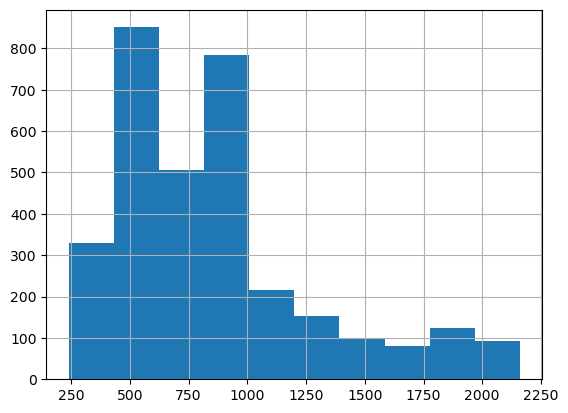

In [7]:
df_train['DurationOfPitch'].hist()

<Axes: >

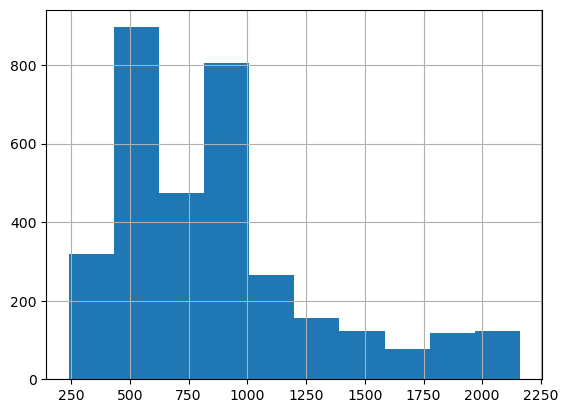

In [8]:
df_test['DurationOfPitch'].hist()

In [9]:
# DurationOfPitch を正規分布に近づける

df_train['DurationOfPitch'] = np.log1p(df_train['DurationOfPitch'])
df_test['DurationOfPitch'] = np.log1p(df_test['DurationOfPitch'])

<Axes: >

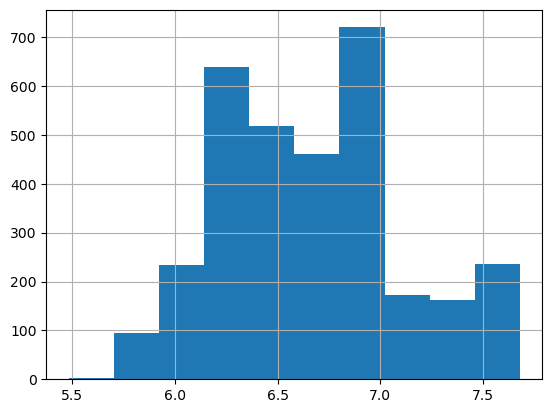

In [10]:
df_train['DurationOfPitch'].hist()

<Axes: >

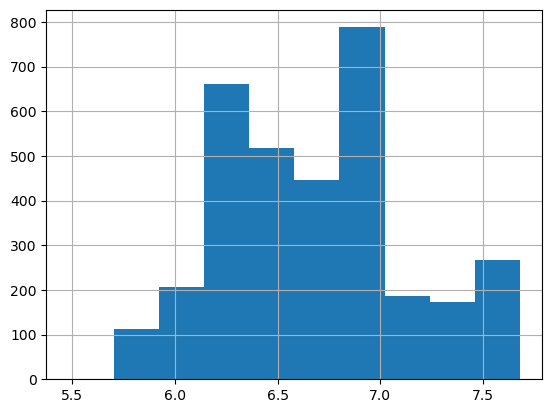

In [11]:
df_test['DurationOfPitch'].hist()

In [12]:
df_train['DurationOfPitch'].isna().sum()

0

In [13]:
df_test['DurationOfPitch'].isna().sum()

131

# 今回調査する欠損値：Age, *DurationOfPitch*, NumberOfTrips, MonthlyIncome

# DurationOfPitch

In [14]:
df_all = pd.concat([df_train, df_test], axis=0)

In [15]:
# DurationOfPitch を予測するための特徴量を選択
predict_duration_feature = ['Age', 'TypeofContact','CityTier','Occupation','Gender','NumberOfPersonVisiting',
                        'NumberOfFollowups','ProductPitched','PreferredPropertyStar','NumberOfTrips' ,'PitchSatisfactionScore', 'Passport','Designation','MonthlyIncome' ,'Marry', 'Car','Child']

# 主キー用idを取得
# id_train = df_train.loc[df_train['DurationOfPitch'].isna()].index
id_test = df_test.loc[df_test['DurationOfPitch'].isna(), 'id'].values

# 目的変数をDurationOfPitchとする
X_train_predict_duration = df_all.loc[~(df_all['DurationOfPitch'].isna()), predict_duration_feature]
X_test_predict_duration = df_all.loc[df_all['DurationOfPitch'].isna(), predict_duration_feature]
y_train_predict_duration = df_all.loc[~(df_all['DurationOfPitch'].isna()), 'DurationOfPitch']
y_test_predict_duration = None

In [17]:
X_train_predict_duration = mapping_columns_if_exist(X_train_predict_duration)
X_test_predict_duration = mapping_columns_if_exist(X_test_predict_duration)
X_train_predict_duration, X_test_predict_duration = feature_to_int(X_train_predict_duration, X_test_predict_duration)

In [20]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(kf.split(X_train_predict_duration, y_train_predict_duration))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'Quantile:alpha=0.5',
    'eval_metric': 'Quantile:alpha=0.5',
    'iterations': 7000,
    'learning_rate': 0.005,
    'depth': 5,
    'l2_leaf_reg': 5,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X_train_predict_duration, y_train_predict_duration, cv_list, params)

0:	learn: 0.1807816	test: 0.1847229	best: 0.1847229 (0)	total: 1.74ms	remaining: 12.2s
100:	learn: 0.1759243	test: 0.1798673	best: 0.1798673 (100)	total: 134ms	remaining: 9.16s
200:	learn: 0.1729960	test: 0.1772993	best: 0.1772993 (200)	total: 263ms	remaining: 8.91s
300:	learn: 0.1710421	test: 0.1757585	best: 0.1757585 (300)	total: 387ms	remaining: 8.62s
400:	learn: 0.1696588	test: 0.1747918	best: 0.1747918 (400)	total: 514ms	remaining: 8.46s
500:	learn: 0.1685792	test: 0.1741793	best: 0.1741793 (500)	total: 642ms	remaining: 8.33s
600:	learn: 0.1676830	test: 0.1737541	best: 0.1737541 (600)	total: 768ms	remaining: 8.17s
700:	learn: 0.1669537	test: 0.1734816	best: 0.1734816 (700)	total: 892ms	remaining: 8.02s
800:	learn: 0.1662780	test: 0.1732275	best: 0.1732275 (800)	total: 1.02s	remaining: 7.9s
900:	learn: 0.1657232	test: 0.1730188	best: 0.1730188 (900)	total: 1.15s	remaining: 7.77s
1000:	learn: 0.1652036	test: 0.1728718	best: 0.1728718 (1000)	total: 1.28s	remaining: 7.66s
1100:	learn:

In [26]:
y_test_predict_duration = np.zeros(len(X_test_predict_duration))

# アンサンブル
for model in models:
    y_test_predict_duration += model.predict(X_test_predict_duration) / len(models)

# y_test_predict_duration = pd.DataFrame({
#     'DurationOfPitch': y_test_predict_duration
# })

In [63]:
# # 訓練データとテストデータに分割する
# predicted_train_duration = y_test_predict_duration.iloc[:len(id_train), 0]
# predicted_test_duration = y_test_predict_duration.iloc[len(id_train): , 0]

# # id(主キー)を与える。
# predicted_train_duration.index = id_train
# predicted_test_duration.index = id_test

In [24]:
df_test[43:50]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
43,3532,19,Company Invited,2,NaN,Salaried,male,1.0,4.0,Basic,3.0,7.0,0,2,Executive,12.631491,Single,No Car,0_child,10s
44,3533,32,Self Enquiry,3,6.803505,Small Business,female,1.0,4.0,Standard,3.0,8.0,0,1,Senior Manager,12.791401,Single,Has Car,0_child,30s
45,3534,31,Self Enquiry,1,6.803505,Salaried,female,1.0,4.0,Standard,3.0,3.0,0,1,Senior Manager,12.931411,Married,Has Car,0_child,30s
46,3535,40,Company Invited,2,6.803505,Small Business,male,1.0,4.0,Deluxe,4.0,1.0,0,1,AVP,13.072660,Divorced,Has Car,0_child,40s
47,3536,56,Company Invited,1,7.528869,Salaried,female,1.0,5.0,Deluxe,3.0,5.0,0,5,AVP,12.941168,Divorced,No Car,0_child,50s
48,3537,24,Company Invited,2,6.734592,Large Business,male,1.0,4.0,Basic,4.0,1.0,1,2,Executive,12.504735,Single,No Car,0_child,20s
49,3538,32,Company Invited,1,NaN,Small Business,male,1.0,3.0,Basic,3.0,2.0,0,2,Executive,12.439151,Single,No Car,0_child,30s


In [29]:
for index, value in zip(id_test, y_test_predict_duration):
    df_test.loc[df_test['id'] == index, 'DurationOfPitch'] = value

In [66]:
# # 欠損値を予測値で補完する
# df_train.loc[df_train['DurationOfPitch'].isna(), 'DurationOfPitch'] = round(predicted_train_duration)
# df_test.loc[df_test['DurationOfPitch'].isna(), 'DurationOfPitch'] = round(predicted_test_duration)

In [30]:
df_test[43:50]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
43,3532,19,Company Invited,2,6.739063,Salaried,male,1.0,4.0,Basic,3.0,7.0,0,2,Executive,12.631491,Single,No Car,0_child,10s
44,3533,32,Self Enquiry,3,6.803505,Small Business,female,1.0,4.0,Standard,3.0,8.0,0,1,Senior Manager,12.791401,Single,Has Car,0_child,30s
45,3534,31,Self Enquiry,1,6.803505,Salaried,female,1.0,4.0,Standard,3.0,3.0,0,1,Senior Manager,12.931411,Married,Has Car,0_child,30s
46,3535,40,Company Invited,2,6.803505,Small Business,male,1.0,4.0,Deluxe,4.0,1.0,0,1,AVP,13.072660,Divorced,Has Car,0_child,40s
47,3536,56,Company Invited,1,7.528869,Salaried,female,1.0,5.0,Deluxe,3.0,5.0,0,5,AVP,12.941168,Divorced,No Car,0_child,50s
48,3537,24,Company Invited,2,6.734592,Large Business,male,1.0,4.0,Basic,4.0,1.0,1,2,Executive,12.504735,Single,No Car,0_child,20s
49,3538,32,Company Invited,1,6.767153,Small Business,male,1.0,3.0,Basic,3.0,2.0,0,2,Executive,12.439151,Single,No Car,0_child,30s


In [33]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [34]:
df_test.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [35]:
df_train.to_csv('data/null_survey/train_all_ok.csv', index=False)
df_test.to_csv('data/null_survey/test_all_ok.csv', index=False)